<a href="https://colab.research.google.com/github/visiont3lab/deep-learning-course/blob/main/colab/Segmentation_micro_sd_card.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Micro-Sd-Card binary segmentation problem

* [IOU vs Dice](https://www.youtube.com/watch?v=AZr64OxshLo)

* [Dice](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient): $dice = \frac{2TP}{2TP + FP + FN} = \frac{2|A \cap B|}{|A| + |B|}$
* [Jaccard Index](https://en.wikipedia.org/wiki/Jaccard_index) $iou =\frac {TP}{TP+FP+FN} = \frac{|A \cap B|}{|A \cup B|} $


## Downlaod Datasets

In [ ]:
# Download dataset link: https://drive.google.com/file/d/1K0LRI_f5Fl8xUGCgU2wtvH2el-EiDThu/view?usp=sharing
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1K0LRI_f5Fl8xUGCgU2wtvH2el-EiDThu' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1K0LRI_f5Fl8xUGCgU2wtvH2el-EiDThu" -O dataset.zip && rm -rf /tmp/cookies.txt
!unzip dataset.zip
!rm dataset.zip 
!mkdir -p dataset
!mv test dataset
!mv train dataset
!mv images dataset

## Imports

In [ ]:
import os
from PIL import Image,ImageFont,ImageDraw
import torch
from torch import nn
from torchvision.transforms.functional import to_tensor,to_pil_image
import torchvision.transforms.functional  as TF
import torch.nn.functional as F
from torch.utils.data import Dataset
import torchvision
from torchvision import transforms
from torchsummary import summary
import numpy as np
import cv2 
import copy
from torch import optim
import random

## Dataset

In [ ]:
# Params
params={
    "folder_train_images_path" : os.path.join("dataset","images"),
    "folder_train_masks_path"  : os.path.join("dataset","train"),
    "folder_test_images_path" : os.path.join("dataset","images"),
    "folder_test_masks_path"  : os.path.join("dataset","test"),
    "folder_images_path" : os.path.join("dataset","images"),
    "model_size" : (256,256)
}

In [ ]:
# Data augmentation
def transformer(image,mask):
    
    # params augmentation
    p_hflip = 0.5
    p_vflip = 0.5
    p_rotate = 0.5
    
    if random.random() < p_hflip:
        image = TF.hflip(image)
        mask  = TF.hflip(mask)
        
    if random.random() <p_vflip:            
        image = TF.vflip(image)
        mask  = TF.vflip(mask)
        
    if random.random() < p_rotate:
        deg = random.uniform(0, 1)*10
        image = TF.rotate(image,deg)
        mask  = TF.rotate(mask,deg)
        
    return image, mask

In [ ]:
# Dataset
class CustomDataset(Dataset):

    def __init__(self, folder_path_images, folder_path_masks,model_size):
        self.folder_path_images = folder_path_images
        self.folder_path_masks = folder_path_masks
        #self.path2images = [ os.path.join(self.folder_path_images,name) for name in os.listdir(self.folder_path_images)]
        self.path2masks = [ os.path.join(folder_path_masks,name) for name in os.listdir(folder_path_masks)]
        self.model_size = model_size
        
    def __getitem__(self, index):
        # Get filepath
        path2mask = self.path2masks[index]
        filename = os.path.basename(path2mask).replace(".png",".jpg")
        path2image = os.path.join(self.folder_path_images,filename)
        # Read image and mask (Opencv H,W,C)
        image = cv2.imread(path2image,cv2.IMREAD_COLOR) # IMREAD_GRAYSCALE
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask  = cv2.imread(path2mask,cv2.IMREAD_GRAYSCALE)
        ret,mask = cv2.threshold(mask,1,255,cv2.THRESH_BINARY) 
        # Get size H,W,C --> if C=1 Grayscale, if C=3 Color
        #image = image[:,:,np.newaxis]
        mask = mask[:,:,np.newaxis]
        # Pil convesion for augmentation
        image = to_pil_image(image)
        mask = to_pil_image(mask)
        # Augmentation
        image,mask = transformer(image,mask)
        # To tensor [0-1] and resize training size
        image = to_tensor( TF.resize( image,self.model_size ) )  # 0-1
        mask = to_tensor( TF.resize( mask, self.model_size ) )   # 0-1
        return image,mask
    
    def __len__(self):
        return len(self.path2masks)

In [ ]:
def visualize(image,mask):
    # Convert image and mask tensors in range 0-1 to numpy 0-255
    image = 255*image.detach().numpy() #[0]
    image = image.astype(np.uint8)
    mask = 255*mask.detach().numpy()[0]
    mask = mask.astype(np.uint8)
    # Overlapping Opencv
    image_col = np.moveaxis(image,0,2) #cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
    mask_col = cv2.cvtColor(mask,cv2.COLOR_GRAY2RGB)
    mask_col[(mask>127)] = [0,255,255]
    overlay = cv2.addWeighted(image_col,0.8,mask_col,0.2,0)
    # Go back to tensors 
    return to_tensor( to_pil_image(overlay) )

In [ ]:
# Dataset generator
train_ds = CustomDataset(params["folder_train_images_path"],params["folder_train_masks_path"],params["model_size"])
test_ds  = CustomDataset(params["folder_test_images_path"] ,params["folder_test_masks_path"],params["model_size"])

# Data loader
train_dl = torch.utils.data.DataLoader(train_ds,batch_size=4,shuffle=True) # 20
test_dl = torch.utils.data.DataLoader(test_ds,batch_size=4,shuffle=True)   # 10

# Verify Test
imgs = []
for batch_images,batch_masks in test_dl: # train_dl test_dl
    for image,mask in zip(batch_images,batch_masks):
        imgs.append( visualize(image,mask) )

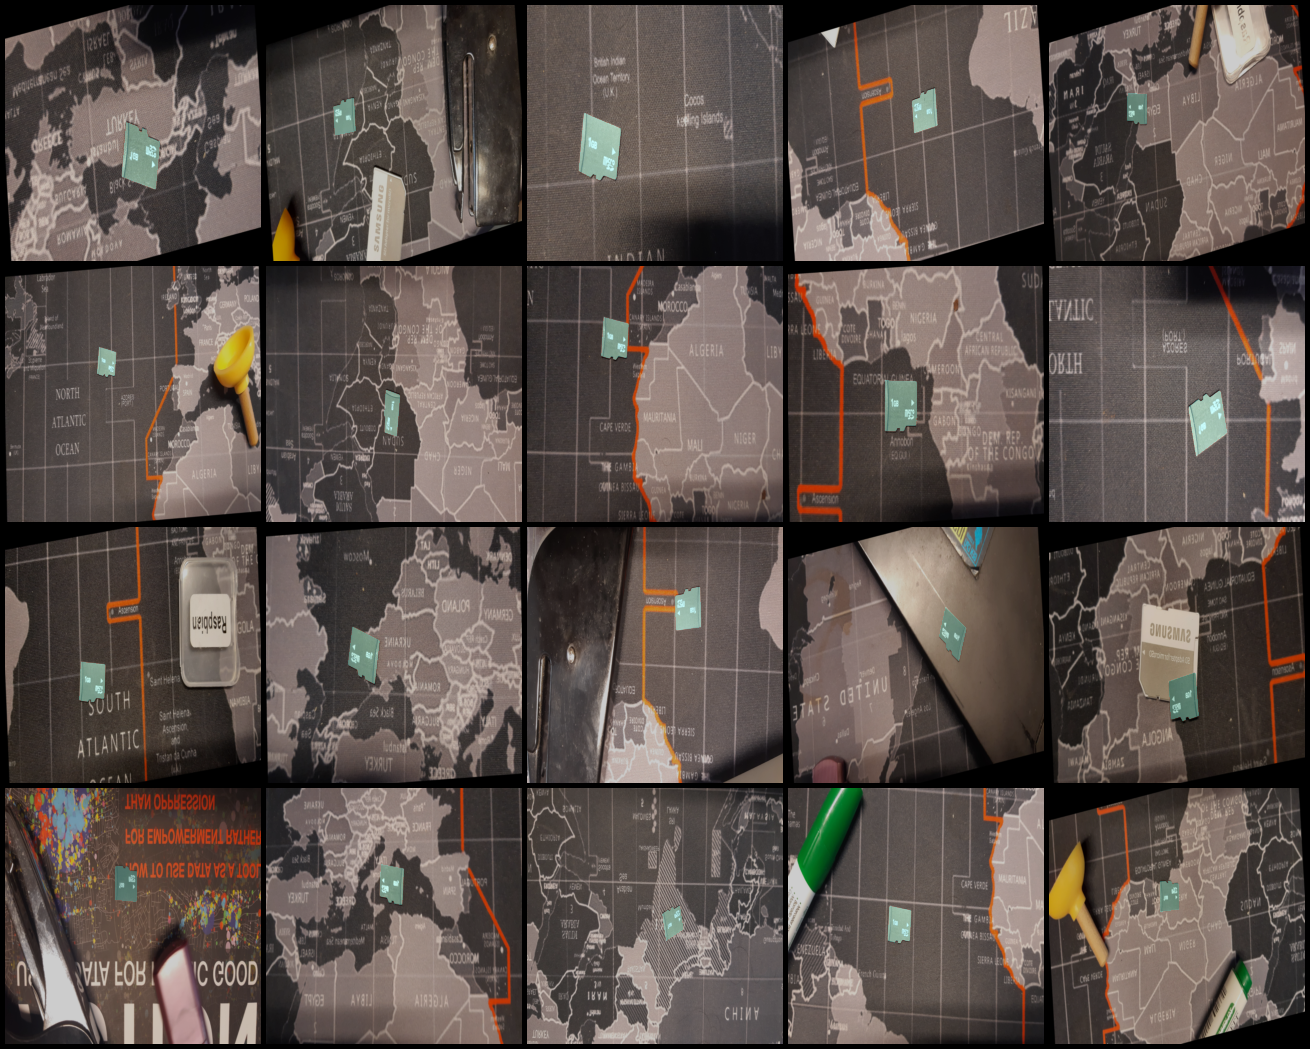

In [ ]:
# Display results (Note display visualize Pil image 0-1)
grid =torchvision.utils.make_grid(torch.stack(imgs,dim=0), nrow=5, padding=5)
display(to_pil_image(grid))

## Model: Option 1) Segnet

In [ ]:
class SegNet(nn.Module):
    
    def __init__(self, params):
        super(SegNet, self).__init__()
        
        C_in, H_in, W_in=params["input_shape"]
        init_f=params["initial_filters"] 
        num_outputs=params["num_outputs"] 

        self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3,stride=1,padding=1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3,stride=1,padding=1)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3,padding=1)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3,padding=1)
        self.conv5 = nn.Conv2d(8*init_f, 16*init_f, kernel_size=3,padding=1)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up1 = nn.Conv2d(16*init_f, 8*init_f, kernel_size=3,padding=1)
        self.conv_up2 = nn.Conv2d(8*init_f, 4*init_f, kernel_size=3,padding=1)
        self.conv_up3 = nn.Conv2d(4*init_f, 2*init_f, kernel_size=3,padding=1)
        self.conv_up4 = nn.Conv2d(2*init_f, init_f, kernel_size=3,padding=1)

        self.conv_out = nn.Conv2d(init_f, num_outputs , kernel_size=3,padding=1)    
        
    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)

        x = F.relu(self.conv5(x))

        x=self.upsample(x)
        x = F.relu(self.conv_up1(x))

        x=self.upsample(x)
        x = F.relu(self.conv_up2(x))
        
        x=self.upsample(x)
        x = F.relu(self.conv_up3(x))
        
        x=self.upsample(x)
        x = F.relu(self.conv_up4(x))

        x = self.conv_out(x)
        
        # Output activation layer --> if u put this use BCELoss not BECLossWithLogit
        x = torch.sigmoid(x)
        
        return x

In [ ]:
h,w = params["model_size"]
params_model ={
        "input_shape": (3,h,w),
        "initial_filters": 16, 
        "num_outputs": 1,
        }
net = SegNet(params_model).to('cpu')
#print(model)
summary(net, input_size=(3, h, w),device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             448
            Conv2d-2         [-1, 32, 128, 128]           4,640
            Conv2d-3           [-1, 64, 64, 64]          18,496
            Conv2d-4          [-1, 128, 32, 32]          73,856
            Conv2d-5          [-1, 256, 16, 16]         295,168
          Upsample-6          [-1, 256, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]         295,040
          Upsample-8          [-1, 128, 64, 64]               0
            Conv2d-9           [-1, 64, 64, 64]          73,792
         Upsample-10         [-1, 64, 128, 128]               0
           Conv2d-11         [-1, 32, 128, 128]          18,464
         Upsample-12         [-1, 32, 256, 256]               0
           Conv2d-13         [-1, 16, 256, 256]           4,624
           Conv2d-14          [-1, 1, 2

## Model: Option 2) Unet 

In [ ]:
class UNet(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3,stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3,stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3,stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3,stride=1, padding=1)
      
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
       
        self.conv_up1 = nn.Conv2d(in_channels=256+128, out_channels=128, kernel_size=3,stride=1, padding=1)    
        self.conv_up2 = nn.Conv2d(in_channels=128+64, out_channels=64, kernel_size=3,stride=1, padding=1)
        self.conv_up3 = nn.Conv2d(in_channels=64+32, out_channels=32, kernel_size=3,stride=1, padding=1)
        self.conv_up4 = nn.Conv2d(in_channels=32+16, out_channels=16, kernel_size=3,stride=1, padding=1)
       
        self.conv_out = nn.Conv2d(16, 1 , kernel_size=3,padding=1) 
            
    def forward(self, x):
        
        conv1 = F.relu( self.conv1(x) )
        x = F.max_pool2d(conv1, 2, 2)
        
        conv2 = F.relu( self.conv2(x) )
        x = F.max_pool2d(conv2, 2, 2)
        
        conv3 = F.relu( self.conv3(x) )
        x = F.max_pool2d(conv3, 2, 2)
        
        conv4 = F.relu( self.conv4(x) )
        x = F.max_pool2d(conv4, 2, 2)
       
        conv5 = F.relu( self.conv5(x) )
    
        x = self.upsample(conv5)
        x = torch.cat([x, conv4], dim=1)

        x = F.relu( self.conv_up1(x))
        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)

        x = F.relu( self.conv_up2(x))
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)

        x = F.relu( self.conv_up3(x))
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)
 
        x = F.relu( self.conv_up4(x))
    
        x = self.conv_out(x)
        
        # Output activation layer --> if u put this use BCELoss not BECLossWithLogit
        x = torch.sigmoid(x)
        
        return x
    
h,w = params["model_size"]
net = UNet().to('cpu')
#print(model)
summary(net, input_size=(3, h, w),device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             448
            Conv2d-2         [-1, 32, 128, 128]           4,640
            Conv2d-3           [-1, 64, 64, 64]          18,496
            Conv2d-4          [-1, 128, 32, 32]          73,856
            Conv2d-5          [-1, 256, 16, 16]         295,168
          Upsample-6          [-1, 256, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]         442,496
          Upsample-8          [-1, 128, 64, 64]               0
            Conv2d-9           [-1, 64, 64, 64]         110,656
         Upsample-10         [-1, 64, 128, 128]               0
           Conv2d-11         [-1, 32, 128, 128]          27,680
         Upsample-12         [-1, 32, 256, 256]               0
           Conv2d-13         [-1, 16, 256, 256]           6,928
           Conv2d-14          [-1, 1, 2

## Training

In [ ]:
# dice loss
def dice_loss(pred, target, smooth = 1e-5):
    intersection = (pred * target).sum(dim=(2,3))
    union= pred.sum(dim=(2,3)) + target.sum(dim=(2,3)) 
    dice= 2.0 * (intersection + smooth) / (union+ smooth)    
    loss = 1.0 - dice
    return loss.sum(), dice.sum()

# dice loss + binary crossentropy
def loss_func(pred, target):
    #bce = F.binary_cross_entropy_with_logits(pred, target,  reduction='sum')
    #pred= torch.sigmoid(pred)
    
    bce = F.binary_cross_entropy(pred, target,  reduction='sum')
    dlv, _ = dice_loss(pred, target)
    loss = bce  + dlv
    return loss

# metrics batch
def metrics_func(target, pred):
    #pred= torch.sigmoid(pred) # if u use F.binary_cross_entropy_with_logits
    _, metric=dice_loss(pred, target)    
    return metric

# training: loss calculation and backward step
def loss_batch(loss_func,metric_func, xb,yb,yb_h, opt=None):
    # obtain loss
    loss = loss_func(yb_h, yb)
    # obtain performance metric 
    with torch.no_grad():
        metric_b = metric_func(yb,yb_h)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.item(), metric_b

# one epoch training
def loss_epoch(model, loss_func,metric_func, dataset_dl, sanity_check,opt, device):
    loss = 0.0
    metric = 0.0
    len_data = float(len(dataset_dl.dataset))
    # get batch data
    for xb,yb in dataset_dl:    
        # send to cuda the data (batch size)
        xb = xb.to(device)
        yb = yb.to(device)
        # obtain model output 
        yb_h = model.forward(xb)
        # loss and metric Calculation
        loss_b, metric_b = loss_batch(loss_func,metric_func, xb,yb,yb_h,opt)
        # update loss
        loss += loss_b
        # update metric
        if metric_b is not None:
            metric+=metric_b 
        if sanity_check is True:
            break
    # average loss
    loss /=len_data
    # average metric
    metric /=len_data
    return loss, metric

# get learning rate from optimizer
def get_lr(opt):
    # opt.param_groups[0]['lr']
    for param_group in opt.param_groups:
        return param_group["lr"]

# trainig - test loop
def train_test(params):
    # --> extract params
    model = params["model"]
    loss_func=params["loss_func"]
    metric_func=params["metric_func"]
    num_epochs=params["num_epochs"]
    opt=params["optimizer"]
    lr_scheduler=params["lr_scheduler"]
    train_dl=params["train_dl"]
    test_dl=params["test_dl"]
    device=params["device"]
    continue_training=params["continue_training"]
    sanity_check=params["sanity_check"]
    path2weigths=params["path2weigths"]
    # --> send model to device and print device
    model = model.to(device)
    print("--> training device %s" % (device))
    # --> if continue_training=True load path2weigths
    if continue_training==True and os.path.isfile(path2weigths):
        print("--> continue training  from last best weights")
        weights = torch.load(path2weigths)
        model.load_state_dict(weights)
    # --> history of loss values in each epoch
    loss_history={"train": [],"test":[]}
    # --> history of metric values in each epoch
    metric_history={"train": [],"test":[]}
    # --> a deep copy of weights for the best performing model
    best_model_weights = copy.deepcopy(model.state_dict())
    # --> initialiaze best loss to large value
    best_loss=float("inf")
    # --> main loop
    for epoch in range(num_epochs):
        # --> get learning rate
        lr = get_lr(opt)
        print("----\nEpoch %s/%s, lr=%.6f" % (epoch+1,num_epochs,lr))
        # --> train model on training dataset
        # we tell to the model to enter in train state. it is important because
        # there are somelayers like dropout, batchnorm that behaves 
        # differently between train and test
        model.train()
        train_loss,train_metric = loss_epoch(model, loss_func, metric_func,train_dl,sanity_check, opt,device)
        # --> collect loss and metric for training dataset
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        # --> tell the model to be in test (validation) mode
        model.eval()
        with torch.no_grad():
            test_loss, test_metric = loss_epoch(model, loss_func, metric_func, test_dl,sanity_check,opt=None,device=device)
        # --> collect loss and metric for test dataset
        loss_history["test"].append(test_loss)
        metric_history["test"].append(test_metric)
        # --> store best model
        if test_loss < best_loss:
            print("--> model improved! --> saved to %s" %(path2weigths))
            best_loss = test_loss
            best_model_weights = copy.deepcopy(model.state_dict())
            # --> store weights into local file
            torch.save(model.state_dict(),path2weigths)
        # --> learning rate scheduler
        lr_scheduler.step()
        print("--> train_loss: %.6f, test_loss: %.6f, train_metric: %.3f, test_metric: %.3f" % (train_loss,test_loss,train_metric,test_metric))
    # --> load best weights
    model.load_state_dict(best_model_weights)
    return model, loss_history,metric_history

# Setup GPU Device
device = torch.device("cpu")
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())
    device = torch.device("cuda:0")
opt = optim.Adam(net.parameters(),lr=0.001) # train with 0.0001 -- 0.00001
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.999)  #  lr = lr * gamma ** last_epoch
params_training = {
    "model":                 net,
    "loss_func":             loss_func, 
    "metric_func":           metrics_func,
    "num_epochs":            100,
    "optimizer":             opt,
    "lr_scheduler":          lr_scheduler,
    "train_dl":              train_dl,
    "test_dl":               test_dl,
    "device":                device,  
    "continue_training" :    False,  # continue training from last save weights
    "sanity_check":          False, # if true we only do one batch per epoch
    "path2weigths":          "./segmentation.pt"  
} 
model, loss_history,metric_history = train_test(params_training)

NameError: ignored

## Export Model Onnx

In [ ]:
# Export Model to onnx
B,C,H,W = 1,3,h,w
dummy_inp = torch.randn(B, C, H, W)

# It's optional to label the input and output layers
#input_names = [ "actual_input_1" ] + [ "learned_%d" % i for i in range(16) ]
#output_names = [ "output1" ]

# Use the exporter from torch to convert to onnx 
# model (that has the weights and net arch)
torch.onnx.export(net.cpu(), dummy_inp, "segmentation.onnx",verbose=True, opset_version=11) # input_names=input_names, output_names=output_names)

## Test

In [ ]:
# Comparison train and test set
device = torch.device("cpu")
net = net.to(device)
net.eval()          
imgs = []
for batch_images,batch_masks in train_dl: # train_dl test_dl
    for image,mask in zip(batch_images,batch_masks):
         with torch.no_grad():
            mask_hat =  net.forward(image.unsqueeze(0)) [0]
            imgs.append( visualize(image,mask_hat) )

In [ ]:
grid =torchvision.utils.make_grid(torch.stack(imgs,dim=0), nrow=5, padding=5)
display(transforms.ToPILImage()(grid))

## HEIC to Jpg

In [ ]:
# https://stuffjasondoes.com/2019/07/10/batch-convert-heic-to-jpg-in-linux/
!apt install libheif-examples
!for f in <heic-folder>/*.HEIC; do echo "Working on file $f"; heif-convert $f $f.jpg; done

## Extra: Visualize images

In [ ]:
import os
import cv2

cv2.namedWindow("im",cv2.WINDOW_NORMAL)
names = os.listdir("images")
for name in names:
    filename = os.path.join("images",name)
    filename_mask = os.path.join("masks",name.replace(".jpg",".png"))
    im = cv2.imread(filename,1)
    mask = cv2.imread(filename_mask,1)
    added_image = cv2.addWeighted(im,0.4,mask,0.6,0)
    print(filename)
    cv2.imshow("im",added_image)
    cv2.waitKey(0)